In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('./data/bike_train.csv')

train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# datetime 컬럼을 datetime 자료형으로 변환
train_df['datetime'] = pd.to_datetime(train_df['datetime'])

# datetime 정보를 연, 월, 일, 시로 분리하여 새로운 열 생성 (분, 초는 의미가 없었죠)
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int32         
 13  month       10886 non-null  int32         
 14  day         10886 non-null  int32         
 15  hour        10886 non-null  int32         
dtypes: datetime64[ns](1), 

In [5]:
from sklearn.model_selection import train_test_split

X = train_df.drop(['datetime', 'count', 'casual', 'registered', 'humidity'], axis=1)
y = train_df['count']

In [6]:
from sklearn.metrics import make_scorer

def rmsle(y_true, y_pred):
    log_true = np.log1p(np.maximum(y_true, 0))
    log_pred = np.log1p(np.maximum(y_pred, 0))
    squared_error = (log_true - log_pred) ** 2
    return np.sqrt(np.mean(squared_error))

# Scikit-learn에서 사용 가능하도록 scorer 생성
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
print("RMSLE Scorer가 성공적으로 생성되었습니다.")

RMSLE Scorer가 성공적으로 생성되었습니다.


In [7]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# 기본 파라미터의 그래디언트 부스팅 모델
gbr = GradientBoostingRegressor(random_state=42)

def k_fold_cross_validation(model, X, y, n_splits=5):
  scores = cross_val_score(model, X, y, cv=n_splits, scoring=rmsle_scorer)
  mean_score = -np.mean(scores)
  print(f"교차 검증 폴드별 RMSLE 점수: {-scores}")
  print(f"평균 RMSLE 점수 (기본 모델): {mean_score:.4f}")

k_fold_cross_validation(gbr, X, y)

교차 검증 폴드별 RMSLE 점수: [1.01893429 0.64271354 0.77797345 0.70555275 0.61987557]
평균 RMSLE 점수 (기본 모델): 0.7530


In [8]:
from sklearn.model_selection import GridSearchCV
# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 5],
    'subsample': [0.8, 1.0]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# 그리드 서치 실행 (시간이 다소 소요될 수 있습니다)
grid_search.fit(X, y)

print(f"최적의 하이퍼파라미터: {grid_search.best_params_}")
print(f"최적 파라미터 적용 시 RMSLE 점수: {-grid_search.best_score_:.4f}")

# 최적의 모델 저장
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
최적의 하이퍼파라미터: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
최적 파라미터 적용 시 RMSLE 점수: 0.5623


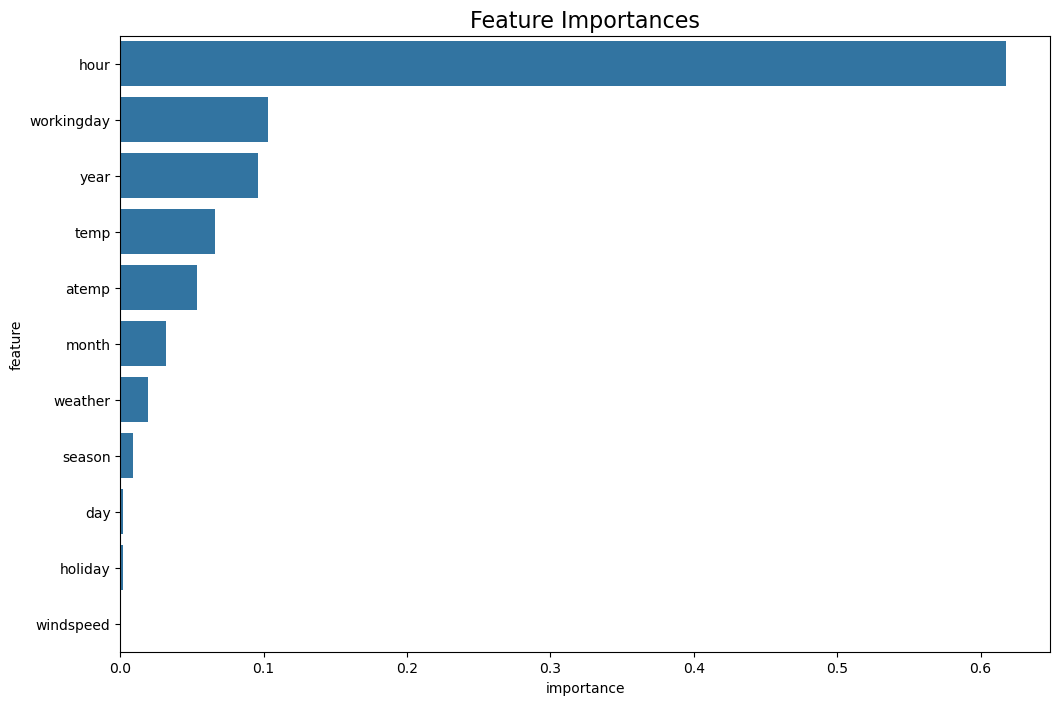

In [9]:
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importances', fontsize=16)
plt.show()

C:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 10 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
C:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
C:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\inspect

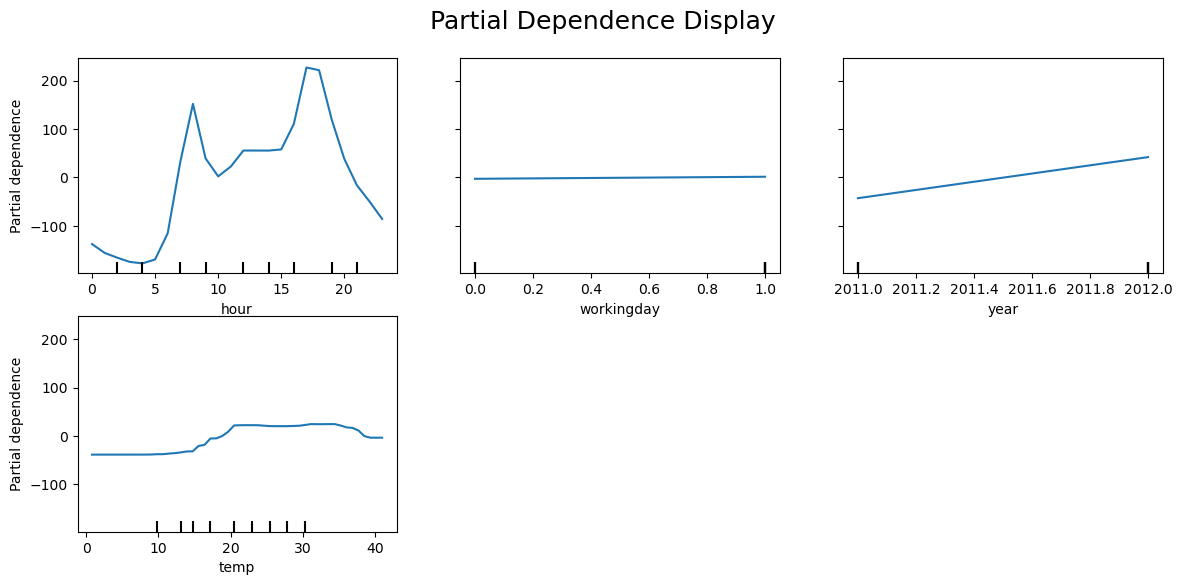

In [16]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(14, 6))
PartialDependenceDisplay.from_estimator(
    best_model,
    X,
    features=['hour', 'workingday', 'year', 'temp'],
    ax=ax
)
fig.suptitle('Partial Dependence Display', fontsize=18)
plt.subplots_adjust(top=0.9)
plt.show()

Feature Importance에서는 크게 나타났던 workingday랑 year가 PDP 관점에서는 크게 변하지 않는 것 같습니다. 왜 이럴까요?

부스팅 초기에 전역적인 효과로 작용했다면, 즉 '전체 분산을 크게 줄이는 데' 효과적이라면 부분적인 효과는 당연히 줄어들겠죠? 

아마 2011년인지, 2012년인지 이 이진 분류 만으로도 모델은 빠르게 경향성을 파악하는데 성공했을 겁니다.

너무나 상호작용이 강했을지도 모릅니다. workingday는 다른 변수와 밀접한 관련을 맺고 있는 것이죠!

[결과 해석]

hour : 오전 8시와 오후 5-6시에 뚜렷한 피크를 보이는 강한 비선형 패턴(출퇴근)을 보입니다.

temp : 온도가 너무 낮으면 수요가 적다가, 20-30도 사이에서 가장 높고, 더 더워지면 감소하는 곡선 형태의 관계를 보입니다. 이러한 복잡한 패턴들은 선형 모델이 학습하기 어렵기 때문에 트리 기반 모델이 우수한 성능을 보인 것입니다.


C:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 10 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
C:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
C:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\inspect

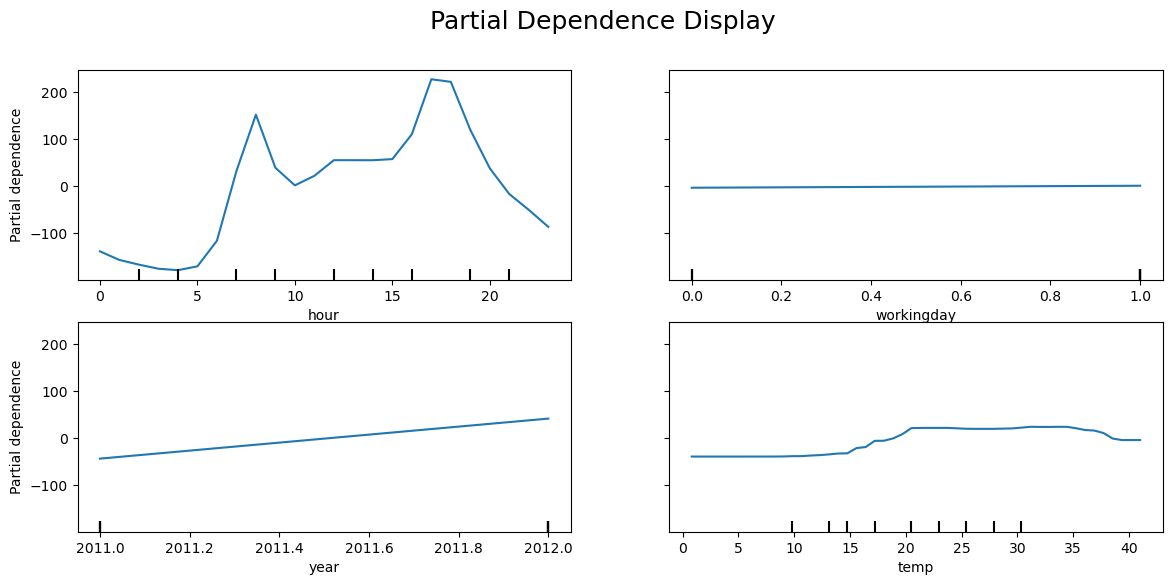

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6))  # 2행 2열 배열
PartialDependenceDisplay.from_estimator(
    best_model,
    X,
    features=['hour', 'workingday', 'year', 'temp'],
    ax=axs
)

fig.suptitle('Partial Dependence Display', fontsize=18)
plt.subplots_adjust()
plt.show()